# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 4912.94 Mb (64.7% reduction)


# Delete Data where Item was not up for Sale

Item is not up for sale when price is NA.

In [5]:
print(df_merged.shape)

df_merged = df_merged.loc[df_merged['sell_price'] > 0]

print(df_merged.shape)

(53662400, 34)
(44307636, 34)


# Model Training & Forecasting (LightGBM)

In [6]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [7]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
    'lag_t1',
    'lag_t7',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [8]:
df_merged['lag_t1'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(1))

df_merged['lag_t7'] = df_merged.groupby(
    ['id'])['sale'].transform(lambda x: x.shift(7))

In [9]:
x_train = df_merged[df_merged['date'] <= '2016-03-27'][features]
y_train = df_merged[df_merged['date'] <= '2016-03-27']['sale']


x_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27'][features]
y_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['sale']

# keep date here, drop later
x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]


print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_pred.shape)

(42600196, 28)
(42600196,)
(853720, 28)
(853720,)
(853720, 28)


In [10]:
# create datasets
train_data = lgb.Dataset(x_train, label=y_train,
                         categorical_feature=cat_features, free_raw_data=False,
                       )
validation_data = lgb.Dataset(
    x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
)

In [11]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.15,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round=1000,
                verbose_eval=25, early_stopping_rounds=20,
                fobj=custom_mse_asymmetric_loss,
                feval=custom_rmse_asymmetric_valid
               )




c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's custom_mse_asymmetric_eval: 2.40131	valid_1's custom_mse_asymmetric_eval: 2.04552
[50]	training's custom_mse_asymmetric_eval: 2.36217	valid_1's custom_mse_asymmetric_eval: 2.03022
[75]	training's custom_mse_asymmetric_eval: 2.34068	valid_1's custom_mse_asymmetric_eval: 2.02571
[100]	training's custom_mse_asymmetric_eval: 2.32362	valid_1's custom_mse_asymmetric_eval: 2.02085
[125]	training's custom_mse_asymmetric_eval: 2.31094	valid_1's custom_mse_asymmetric_eval: 2.01817
[150]	training's custom_mse_asymmetric_eval: 2.30108	valid_1's custom_mse_asymmetric_eval: 2.01405
[175]	training's custom_mse_asymmetric_eval: 2.29242	valid_1's custom_mse_asymmetric_eval: 2.01188
[200]	training's custom_mse_asymmetric_eval: 2.28405	valid_1's custom_mse_asymmetric_eval: 2.0096
[225]	training's custom_mse_asymmetric_eval: 2.27532	valid_1's custom_mse_asymmetric_eval: 2.00901
[250]	training's custom_mse_asymmetric_eval: 2.26818

In [84]:
# keep date here, drop later
#x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]


In [85]:
def forecast_iteratively(df):
    
    # prepare df
    df['date'] = df.year.astype(str) + '-'+df.month.astype(str)+ '-'+df.day.astype(str)
    df.loc[:, 'date'] = pd.to_datetime(df['date'])
    df['y_pred'] = np.nan
    
    c = 0
    for day_i in range(28):

        date_i = (df['date'].dt.date.min() +pd.to_timedelta(day_i, unit='d'))
        date_lag1 = date_i -pd.to_timedelta(1, unit='day')
        date_lag7 = date_i -pd.to_timedelta(7, unit='day')


        df_i = df.loc[df.date == str(date_i)][features].copy()
        rel_index = df_i.index.to_list()

        if str(df_i.lag_t1.values[0]) == 'nan':
            df_i['lag_t1'] = df.loc[df.date == str(date_lag1)]['lag_t1'].values
            df.loc[rel_index,['lag_t1']] = df.loc[df.date == str(date_lag1)]['lag_t1'].values

        if str(df_i.lag_t7.values[0]) == 'nan':
            df_i['lag_t7'] = df.loc[df.date == str(date_lag7)]['lag_t7'].values
            df.loc[rel_index,['lag_t7']] = df.loc[df.date == str(date_lag7)]['lag_t7'].values


        y_pred_i = gbm.predict(df_i[features], num_iteration=gbm.best_iteration)
        df.loc[rel_index,['y_pred']] = y_pred_i

    return df.y_pred.values



In [86]:
y_pred = forecast_iteratively(x_pred.copy())


# Training Analysis

Plotting metrics recorded during training...


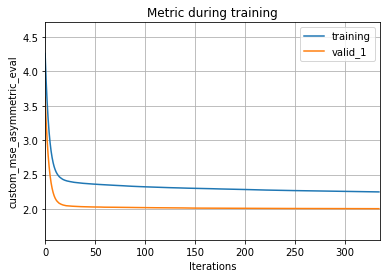

In [87]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

Plotting feature importances...


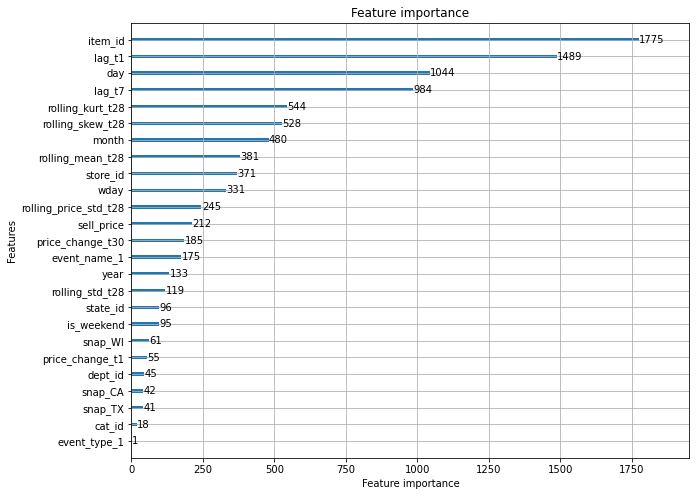

In [88]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, figsize=(10,8))
plt.show()

# Compute RMSSE and WRMSSE on Validation Data

In [90]:
# compute forecasts, error and map it to df_merged to get ids
df_tmp = x_val.copy()
df_tmp['y_pred'] = gbm.predict(x_val[features], num_iteration=gbm.best_iteration)
df_tmp['y_true'] = y_val
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp = df_tmp.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,date,y_pred,y_true,error,id
0,1437,3,1,0,0,2016,3,28,0,3,...,1.000000,1.231763,0.0,0.0,8.622286e-08,2016-03-28,0.932415,1.0,0.067585,HOBBIES_1_001_CA_1_validation
1,1437,3,1,0,0,2016,3,29,0,4,...,1.033333,1.245221,0.0,0.0,8.622286e-08,2016-03-29,1.025264,0.0,-1.025264,HOBBIES_1_001_CA_1_validation
2,1437,3,1,0,0,2016,3,30,0,5,...,1.000000,1.259447,0.0,0.0,8.622286e-08,2016-03-30,0.868122,0.0,-0.868122,HOBBIES_1_001_CA_1_validation
3,1437,3,1,0,0,2016,3,31,0,6,...,1.000000,1.259447,0.0,0.0,8.622286e-08,2016-03-31,0.664247,0.0,-0.664247,HOBBIES_1_001_CA_1_validation
4,1437,3,1,0,0,2016,4,1,0,7,...,1.000000,1.259447,0.0,0.0,8.622286e-08,2016-04-01,0.955511,0.0,-0.955511,HOBBIES_1_001_CA_1_validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,1436,2,0,9,2,2016,4,20,0,5,...,1.766667,1.715715,0.0,0.0,0.000000e+00,2016-04-20,1.097786,0.0,-1.097786,FOODS_3_827_WI_3_validation
853716,1436,2,0,9,2,2016,4,21,0,6,...,1.766667,1.715715,0.0,0.0,0.000000e+00,2016-04-21,1.249625,0.0,-1.249625,FOODS_3_827_WI_3_validation
853717,1436,2,0,9,2,2016,4,22,0,7,...,1.833333,1.683251,0.0,0.0,0.000000e+00,2016-04-22,1.069718,0.0,-1.069718,FOODS_3_827_WI_3_validation
853718,1436,2,0,9,2,2016,4,23,1,1,...,1.833333,1.683251,0.0,0.0,0.000000e+00,2016-04-23,1.182859,0.0,-1.182859,FOODS_3_827_WI_3_validation


In [91]:
# compute RMSSE and store it in dict
rmsse_dict = {}

for name, group in df_tmp.groupby(['id']):
    
    scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
    weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]
    
    rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
    

In [92]:
# convert dict to dataframe
rmsse_df = pd.DataFrame(rmsse_dict).T
rmsse_df['id'] = rmsse_df.index
rmsse_df = rmsse_df.reset_index(drop=True)
rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

# add weights to df and compute weights multiplied by RMSSE
rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

# sort values by their impact
rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)


In [93]:
# compute WRMSSE
print('WRMSSE = %0.5f' % np.sum(rmsse_df.RMSSE * rmsse_df.weights))
# WRMSSE = 0.01167

WRMSSE = 0.85138


In [94]:
# show RMSSE and corresponding weights
rmsse_df.head(25).sort_values(by='w_times_RMSSE', ascending=False)

,RMSSE,id,weights,w_times_RMSSE
20322,4.902768,HOUSEHOLD_1_032_CA_3_validation,0.000218,0.001069
20324,3.833546,HOUSEHOLD_1_032_TX_1_validation,0.000134,0.000514
26759,3.528991,HOUSEHOLD_2_142_WI_3_validation,0.000121,0.000427
23802,3.243135,HOUSEHOLD_1_386_CA_3_validation,0.000083,0.000269
7871,2.778995,FOODS_3_175_CA_2_validation,0.000078,0.000217
22731,3.203541,HOUSEHOLD_1_278_CA_2_validation,0.000056,0.000179
21772,4.554777,HOUSEHOLD_1_180_CA_3_validation,0.000038,0.000175
23801,3.240896,HOUSEHOLD_1_386_CA_2_validation,0.000051,0.000164
2201,3.149616,FOODS_2_005_CA_2_validation,0.000037,0.000116
4940,2.829109,FOODS_2_280_CA_1_validation,0.000039,0.000111


In [95]:
# analyse time series with max. RMSSE
df_tmp.loc[df_tmp.id == rmsse_df.loc[0,'id']][['id', 'month', 'day','up_for_sale','event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2','is_weekend','wday', 'sell_price', 'y_pred', 'y_true', 'error',]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error
45136,FOODS_1_001_CA_1_validation,3,28,1,13,1,3,1,0,3,2.24,0.486398,2.0,1.513602
45137,FOODS_1_001_CA_1_validation,3,29,1,13,1,3,1,0,4,2.24,0.859840,1.0,0.140160
45138,FOODS_1_001_CA_1_validation,3,30,1,13,1,3,1,0,5,2.24,0.804576,1.0,0.195424
45139,FOODS_1_001_CA_1_validation,3,31,1,13,1,3,1,0,6,2.24,0.688827,0.0,-0.688827
45140,FOODS_1_001_CA_1_validation,4,1,1,13,1,3,1,0,7,2.24,0.707548,4.0,3.292452
45141,FOODS_1_001_CA_1_validation,4,2,1,13,1,3,1,1,1,2.24,1.492196,0.0,-1.492196
45142,FOODS_1_001_CA_1_validation,4,3,1,13,1,3,1,1,2,2.24,0.599207,0.0,-0.599207
45143,FOODS_1_001_CA_1_validation,4,4,1,13,1,3,1,0,3,2.24,0.660054,4.0,3.339946
45144,FOODS_1_001_CA_1_validation,4,5,1,13,1,3,1,0,4,2.24,1.213020,1.0,-0.213020
45145,FOODS_1_001_CA_1_validation,4,6,1,13,1,3,1,0,5,2.24,0.677957,3.0,2.322043


In [96]:
# analyse time series (manually)
rel_id = 'FOODS_2_181_WI_2_validation'
df_tmp.loc[df_tmp.id == rel_id][['id', 'month', 'day','up_for_sale','event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2','is_weekend','wday', 'sell_price', 'y_pred', 'y_true', 'error',]]

,id,month,day,up_for_sale,event_name_1,event_type_1,event_name_2,event_type_2,is_weekend,wday,sell_price,y_pred,y_true,error
739172,FOODS_2_181_WI_2_validation,3,28,1,13,1,3,1,0,3,1.78,16.840017,25.0,8.159983
739173,FOODS_2_181_WI_2_validation,3,29,1,13,1,3,1,0,4,1.78,19.904378,31.0,11.095622
739174,FOODS_2_181_WI_2_validation,3,30,1,13,1,3,1,0,5,1.78,26.559723,20.0,-6.559723
739175,FOODS_2_181_WI_2_validation,3,31,1,13,1,3,1,0,6,1.78,25.039035,26.0,0.960965
739176,FOODS_2_181_WI_2_validation,4,1,1,13,1,3,1,0,7,1.78,34.144338,45.0,10.855662
739177,FOODS_2_181_WI_2_validation,4,2,1,13,1,3,1,1,1,1.78,43.772551,53.0,9.227449
739178,FOODS_2_181_WI_2_validation,4,3,1,13,1,3,1,1,2,1.78,48.793784,63.0,14.206216
739179,FOODS_2_181_WI_2_validation,4,4,1,13,1,3,1,0,3,1.78,30.922071,36.0,5.077929
739180,FOODS_2_181_WI_2_validation,4,5,1,13,1,3,1,0,4,1.78,39.083544,60.0,20.916456
739181,FOODS_2_181_WI_2_validation,4,6,1,13,1,3,1,0,5,1.78,49.219097,54.0,4.780903


# Error for different Predicting Intervals

In [108]:
# compute forecasts, error and map it to df_merged to get ids
df_tmp = x_val.copy()
df_tmp['y_pred'] = forecast_iteratively(x_val)
df_tmp['y_true'] = y_val
df_tmp['error'] = (df_tmp.y_true - df_tmp.y_pred)
df_tmp = df_tmp.merge(df_merged[['id', 'item_id','dept_id','cat_id', 'store_id', 'state_id']].drop_duplicates())

df_tmp

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,date,y_pred,y_true,error,id
0,1437,3,1,0,0,2016,3,28,0,3,...,1.000000,1.231763,0.0,0.0,8.622286e-08,2016-03-28,0.932415,1.0,0.067585,HOBBIES_1_001_CA_1_validation
1,1437,3,1,0,0,2016,3,29,0,4,...,1.033333,1.245221,0.0,0.0,8.622286e-08,2016-03-29,1.025264,0.0,-1.025264,HOBBIES_1_001_CA_1_validation
2,1437,3,1,0,0,2016,3,30,0,5,...,1.000000,1.259447,0.0,0.0,8.622286e-08,2016-03-30,0.868122,0.0,-0.868122,HOBBIES_1_001_CA_1_validation
3,1437,3,1,0,0,2016,3,31,0,6,...,1.000000,1.259447,0.0,0.0,8.622286e-08,2016-03-31,0.664247,0.0,-0.664247,HOBBIES_1_001_CA_1_validation
4,1437,3,1,0,0,2016,4,1,0,7,...,1.000000,1.259447,0.0,0.0,8.622286e-08,2016-04-01,0.955511,0.0,-0.955511,HOBBIES_1_001_CA_1_validation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853715,1436,2,0,9,2,2016,4,20,0,5,...,1.766667,1.715715,0.0,0.0,0.000000e+00,2016-04-20,1.097786,0.0,-1.097786,FOODS_3_827_WI_3_validation
853716,1436,2,0,9,2,2016,4,21,0,6,...,1.766667,1.715715,0.0,0.0,0.000000e+00,2016-04-21,1.249625,0.0,-1.249625,FOODS_3_827_WI_3_validation
853717,1436,2,0,9,2,2016,4,22,0,7,...,1.833333,1.683251,0.0,0.0,0.000000e+00,2016-04-22,1.069718,0.0,-1.069718,FOODS_3_827_WI_3_validation
853718,1436,2,0,9,2,2016,4,23,1,1,...,1.833333,1.683251,0.0,0.0,0.000000e+00,2016-04-23,1.182859,0.0,-1.182859,FOODS_3_827_WI_3_validation


In [109]:
tmp = df_tmp[['id', 'year', 'month', 'day', 'y_pred', 'y_true', 'error']]
tmp_grouped = tmp.groupby(['year', 'month', 'day'])


for date, row in tmp_grouped:
    
    # compute RMSSE and store it in dict
    rmsse_dict = {}

    for name, group in row.groupby(['id']):

        scale = scaling_factors_rmsse.loc[scaling_factors_rmsse['id'] == name]['scaling_factor'].to_list()[0]
        weight = weights_wrmsse.loc[weights_wrmsse['id'] == name]['weights'].values[0]

        rmsse_dict[name] = [np.sqrt(np.mean(group.error**2 / scale))]
        
        
    # convert dict to dataframe
    rmsse_df = pd.DataFrame(rmsse_dict).T
    rmsse_df['id'] = rmsse_df.index
    rmsse_df = rmsse_df.reset_index(drop=True)
    rmsse_df = rmsse_df.rename(columns={0:'RMSSE'})

    # add weights to df and compute weights multiplied by RMSSE
    rmsse_df = rmsse_df.merge(weights_wrmsse, how='inner')
    rmsse_df['w_times_RMSSE'] = rmsse_df.loc[:,'weights'] * rmsse_df.loc[:,'RMSSE']

    # sort values by their impact
    rmsse_df = rmsse_df.sort_values(by='RMSSE', ascending=False)

    print('WRMSSE of %s = %0.5f' % (date, np.sum(rmsse_df.RMSSE * rmsse_df.weights)))
    # WRMSSE overall = 0.01167

    
    


WRMSSE of (2016, 3, 28) = 0.60059
WRMSSE of (2016, 3, 29) = 0.57595
WRMSSE of (2016, 3, 30) = 0.56818
WRMSSE of (2016, 3, 31) = 0.60173
WRMSSE of (2016, 4, 1) = 0.71392
WRMSSE of (2016, 4, 2) = 0.76050
WRMSSE of (2016, 4, 3) = 0.80463
WRMSSE of (2016, 4, 4) = 0.65949
WRMSSE of (2016, 4, 5) = 0.64799
WRMSSE of (2016, 4, 6) = 0.64564
WRMSSE of (2016, 4, 7) = 0.62708
WRMSSE of (2016, 4, 8) = 0.67116
WRMSSE of (2016, 4, 9) = 0.77387
WRMSSE of (2016, 4, 10) = 0.78563
WRMSSE of (2016, 4, 11) = 0.68360
WRMSSE of (2016, 4, 12) = 0.65032
WRMSSE of (2016, 4, 13) = 0.60369
WRMSSE of (2016, 4, 14) = 0.63390
WRMSSE of (2016, 4, 15) = 0.67601
WRMSSE of (2016, 4, 16) = 0.71154
WRMSSE of (2016, 4, 17) = 0.74957
WRMSSE of (2016, 4, 18) = 0.64196
WRMSSE of (2016, 4, 19) = 0.61751
WRMSSE of (2016, 4, 20) = 0.59715
WRMSSE of (2016, 4, 21) = 0.60099
WRMSSE of (2016, 4, 22) = 0.62207
WRMSSE of (2016, 4, 23) = 0.68925
WRMSSE of (2016, 4, 24) = 0.73895


# Printout Forecasts

In [98]:
# map forecast values to encoded item_ids
x_pred['y_pred'] = y_pred

In [99]:
x_pred

,item_id,dept_id,cat_id,store_id,state_id,year,month,day,is_weekend,wday,...,lag_t1,lag_t7,rolling_kurt_t28,rolling_skew_t28,rolling_mean_t28,rolling_std_t28,price_change_t1,price_change_t30,rolling_price_std_t28,y_pred
52808680,1437,3,1,0,0,2016,4,25,0,3,...,1.0,1.0,0.246603,0.763245,1.033333,0.927858,0.0,0.0,5.968164e-02,0.940615
52808681,1438,3,1,0,0,2016,4,25,0,3,...,0.0,0.0,-1.731692,0.744880,0.333333,0.479463,0.0,0.0,0.000000e+00,0.217723
52808682,1439,3,1,0,0,2016,4,25,0,3,...,1.0,1.0,16.585960,3.904594,0.500000,1.167077,0.0,0.0,0.000000e+00,0.567543
52808683,1440,3,1,0,0,2016,4,25,0,3,...,2.0,4.0,-0.529831,0.790924,1.966667,2.075860,0.0,0.0,0.000000e+00,2.113964
52808684,1441,3,1,0,0,2016,4,25,0,3,...,4.0,0.0,-0.717982,0.542001,1.100000,0.959526,0.0,0.0,4.434852e-08,0.895079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53662395,1432,2,0,9,2,2016,5,22,1,2,...,NaN,NaN,6.029183,2.758372,0.200000,0.550861,0.0,0.0,7.810822e-08,0.560294
53662396,1433,2,0,9,2,2016,5,22,1,2,...,NaN,NaN,1.580669,1.621490,0.300000,0.534983,0.0,0.0,4.964984e-08,0.220466
53662397,1434,2,0,9,2,2016,5,22,1,2,...,NaN,NaN,1.720479,1.485839,0.866667,1.136642,0.0,0.0,0.000000e+00,0.637997
53662398,1435,2,0,9,2,2016,5,22,1,2,...,NaN,NaN,-0.140881,0.963120,1.066667,1.172481,0.0,0.0,0.000000e+00,1.789137


In [100]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'year', 'month', 'day','store_id']].drop_duplicates()
df_results = x_pred.merge(id_mapping_table,
                         on=['item_id', 'store_id', 'year', 'month', 'day'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [101]:
id_mapping_table

,id,item_id,year,month,day,store_id
1,HOBBIES_1_002_CA_1_validation,1438,2011,7,29,0
3,HOBBIES_1_004_CA_1_validation,1440,2011,7,29,0
4,HOBBIES_1_005_CA_1_validation,1441,2011,7,29,0
7,HOBBIES_1_008_CA_1_validation,1444,2011,7,29,0
8,HOBBIES_1_009_CA_1_validation,1445,2011,7,29,0
...,...,...,...,...,...,...
53662395,FOODS_3_823_WI_3_validation,1432,2016,5,22,9
53662396,FOODS_3_824_WI_3_validation,1433,2016,5,22,9
53662397,FOODS_3_825_WI_3_validation,1434,2016,5,22,9
53662398,FOODS_3_826_WI_3_validation,1435,2016,5,22,9


In [102]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [103]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
f_list = [f'F{di}' for di in list(range(1, 29))]
submission_df.columns = ['id'] + f_list
submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.932805,0.712886,0.707417,0.583343,0.911736,1.038825,0.845485,1.080293,0.891925,...,1.039876,1.175822,0.824663,1.130960,0.946189,0.951505,0.650713,0.911049,1.036855,0.789431
1,FOODS_1_001_CA_2_validation,1.074719,1.131724,1.121978,1.460199,1.136810,1.503487,2.088956,1.164586,1.214637,...,1.103910,1.249193,2.577238,1.186093,1.223014,1.228331,1.819116,1.423348,1.600597,2.319670
2,FOODS_1_001_CA_3_validation,0.784593,0.695511,0.690042,0.693818,0.750623,1.063290,0.876350,0.731012,0.661145,...,0.771223,1.074599,1.091803,0.815093,0.796340,0.801657,0.801550,0.855693,1.172740,0.931715
3,FOODS_1_001_CA_4_validation,0.753892,0.614076,0.606712,0.610488,0.719183,0.847177,0.841147,0.866211,0.706537,...,0.517070,0.604207,0.628710,0.576180,0.390554,0.362287,0.362180,0.479719,0.577845,0.553650
4,FOODS_1_001_TX_1_validation,0.408567,0.419352,0.413883,0.417659,0.432495,0.502562,0.541353,0.463754,0.394331,...,0.240330,0.240807,0.241343,0.142922,0.137412,0.136837,0.136731,0.140382,0.180580,0.121177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.186144,0.191764,0.319309,0.195235,0.221389,0.270644,0.292231,0.224126,0.264625,...,0.237186,0.331586,0.276801,0.199608,0.199263,0.332429,0.204473,0.227964,0.271477,0.247283
30486,HOUSEHOLD_2_516_TX_3_validation,0.118106,0.132249,0.133816,0.135720,0.145453,0.180282,0.191305,0.114230,0.131387,...,0.403875,0.222966,0.219235,0.172547,0.172201,0.177517,0.177411,0.184481,0.224680,0.200486
30487,HOUSEHOLD_2_516_WI_1_validation,0.063950,0.063679,0.063375,0.067150,0.116852,0.159897,0.168697,0.077044,0.091819,...,0.125686,0.154342,0.150611,0.064261,0.063915,0.069231,0.069125,0.116164,0.156056,0.131862
30488,HOUSEHOLD_2_516_WI_2_validation,0.069510,0.075131,0.074827,0.240036,0.088335,0.125848,0.134648,0.096378,0.111153,...,0.064405,0.085540,0.081808,0.048841,0.048495,0.053811,0.242010,0.087647,0.114125,0.089931


# Increase Predictions for Food Items as they are underestimated

In [104]:
food_list = []
for i in rmsse_df.head(50).itertuples():
    if 'FOODS' in i.id:
        food_list.append(i.id)

In [105]:
submission_df.loc[submission_df.id.isin(food_list),
                  f_list] = submission_df.loc[submission_df.id.isin(food_list),
                                            f_list] * 1.4

submission_df

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.932805,0.712886,0.707417,0.583343,0.911736,1.038825,0.845485,1.080293,0.891925,...,1.039876,1.175822,0.824663,1.130960,0.946189,0.951505,0.650713,0.911049,1.036855,0.789431
1,FOODS_1_001_CA_2_validation,1.074719,1.131724,1.121978,1.460199,1.136810,1.503487,2.088956,1.164586,1.214637,...,1.103910,1.249193,2.577238,1.186093,1.223014,1.228331,1.819116,1.423348,1.600597,2.319670
2,FOODS_1_001_CA_3_validation,0.784593,0.695511,0.690042,0.693818,0.750623,1.063290,0.876350,0.731012,0.661145,...,0.771223,1.074599,1.091803,0.815093,0.796340,0.801657,0.801550,0.855693,1.172740,0.931715
3,FOODS_1_001_CA_4_validation,0.753892,0.614076,0.606712,0.610488,0.719183,0.847177,0.841147,0.866211,0.706537,...,0.517070,0.604207,0.628710,0.576180,0.390554,0.362287,0.362180,0.479719,0.577845,0.553650
4,FOODS_1_001_TX_1_validation,0.408567,0.419352,0.413883,0.417659,0.432495,0.502562,0.541353,0.463754,0.394331,...,0.240330,0.240807,0.241343,0.142922,0.137412,0.136837,0.136731,0.140382,0.180580,0.121177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.186144,0.191764,0.319309,0.195235,0.221389,0.270644,0.292231,0.224126,0.264625,...,0.237186,0.331586,0.276801,0.199608,0.199263,0.332429,0.204473,0.227964,0.271477,0.247283
30486,HOUSEHOLD_2_516_TX_3_validation,0.118106,0.132249,0.133816,0.135720,0.145453,0.180282,0.191305,0.114230,0.131387,...,0.403875,0.222966,0.219235,0.172547,0.172201,0.177517,0.177411,0.184481,0.224680,0.200486
30487,HOUSEHOLD_2_516_WI_1_validation,0.063950,0.063679,0.063375,0.067150,0.116852,0.159897,0.168697,0.077044,0.091819,...,0.125686,0.154342,0.150611,0.064261,0.063915,0.069231,0.069125,0.116164,0.156056,0.131862
30488,HOUSEHOLD_2_516_WI_2_validation,0.069510,0.075131,0.074827,0.240036,0.088335,0.125848,0.134648,0.096378,0.111153,...,0.064405,0.085540,0.081808,0.048841,0.048495,0.053811,0.242010,0.087647,0.114125,0.089931


# Submit to Kaggle 

In [106]:
if submit_to_kaggle:
    # Bring data to Kaggel's required form (evaluation & validation)
    df_submission = submission_df.append(
        submission_df.replace(to_replace='validation', value='evaluation',
                              regex=True))
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
    df_submission.to_csv(filename, index=False)
    

    # Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
    !kaggle competitions submit -c m5-forecasting-accuracy -f data/submissions/gradient_boosting_regressor_v_2_5.csv -m "asymetric loss with factor 1.1 if res > 1"


In [107]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation', value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
df_submission.to_csv(filename, index=False)